# **1. Librerías usadas**

In [ ]:
#Starndard libreries
import os
import sys
import io
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#import libreries of NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

#import optimization
from scipy.optimize import minimize
import scipy.optimize

In [ ]:
1*np.finfo(float).eps

np.float64(2.220446049250313e-16)

# **2. Entrenamiento del la PINN**

## **2.1. PRIMERA PARTE: Encontrar los mínimos con Adam + LRA (Cálculo con Float-32)**

In [ ]:
#Configurar la seed
tf.random.set_seed(0)
np.random.seed(0)

# Parámetros físicos
sigma = 1.0
k0_sim = [1.0, 2.0]  # Modos usados en la simulación
A_sim = [2, 1]       # Amplitudes usadas en la simulación
k_boost = 0.0        # Boost usado en la simulación
m = 0.511            # Masa
c = 1.0              # Velocidad de la luz en unidades naturales

#Parámetros iniciales
N = 1000
L = 80*sigma
dx = L / N
m = 0.511

# Dominio
N = 1000
T = L/2 - 4*sigma
dt = T / N
k_fft = 2 * np.pi * np.fft.fftfreq(N, d=dx)

#Definción de ondas
x = np.linspace(-L/2, L/2, N, endpoint=False)

kvec = 2 * np.pi * np.fft.fftfreq(N, d=dx)
omega_k = np.sqrt(kvec**2 + m**2)

#Parámetros para el escalamiento
X_min = -L/2
X_max = L/2  # Ejemplo
T_min = 0.0
T_max = T

In [ ]:
def condition_initial(x, sigma, k0, k_boost, m, A, dx):
    # Vectorizamos las listas
    k0_arr = np.array(k0).reshape(-1, 1)
    A_arr = np.array(A).reshape(-1, 1)
    x_arr = x.reshape(1, -1)
    aux = np.dot(k0_arr, x_arr)

    # Suma ponderada de exponenciales; sum( A_i * exp(i * k_i * x) )
    fase_estacionaria = np.sum(A_arr * np.exp(1j * k0_arr * x_arr) + A_arr*np.exp(-1j * k0_arr * x_arr), axis=0)
    # Reshape fase_estacionaria to (N, 1) to ensure correct element-wise multiplication
    fase_estacionaria = fase_estacionaria.reshape(-1, 1)

    psi_static = np.exp(-(x**2)/(2 * sigma**2)) * fase_estacionaria

    # Multiplicamos todo por una onda viajera pura.
    psi_moving = psi_static * np.exp(1j * k_boost * x)
    psi_moving = psi_moving / np.sqrt(np.max(np.abs(psi_moving)**2))

    # Calculamos condiciones iniciales para el solver
    phi0 = psi_moving.real
    phi0 = phi0 / np.sqrt(np.max(np.abs(phi0)**2))

    # Derivada automática con FFT
    phi_k = np.fft.fft(psi_moving.flatten()) # Flatten before FFT as FFT expects 1D or ND-array
    k_freqs = 2 * np.pi * np.fft.fftfreq(len(x), d=dx)
    omega_k = np.sqrt(k_freqs**2 + m**2)

    pi_k_calc = -1j * omega_k * phi_k
    pi0 = np.fft.ifft(pi_k_calc).real.reshape(-1, 1) # Reshape back to (N,1)

    return phi0, pi0

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import tensorflow as tf
from scipy.interpolate import interp1d

# ==========================================
# CONFIGURACIÓN PREVIA Y GRID FÍSICO
# ==========================================
# Asegúrate de usar float64 para que L-BFGS no falle
tf.keras.backend.set_floatx('float64')

# Definir límites (Asumiendo que L, T ya están definidos en tu código anterior)
X_min, X_max = -L/2, L/2
T_min, T_max = 0, T

# Grid espacial denso para generar la Condición Inicial exacta (Ground Truth)
# Necesario para crear las funciones interp_phi0 e interp_pi0
x_grid = np.linspace(X_min, X_max, 2000).reshape(-1, 1) # Malla fina

# Generar los valores reales de la condición inicial en el grid
phi0_vals, pi0_vals = condition_initial(
    x=x_grid,
    sigma=sigma,
    k0=k0_sim,
    k_boost=0.0,
    A=[2, 1],
    m=m,
    dx=dx
)

# Crear interpoladores (Aceptan coordenadas FÍSICAS)
interp_phi0 = interp1d(x_grid.flatten(), phi0_vals.flatten(), kind='cubic', fill_value="extrapolate")
interp_pi0  = interp1d(x_grid.flatten(), pi0_vals.flatten(), kind='cubic', fill_value="extrapolate")

# Función robusta para convertir a tensores
def to_tensor(v):
    # Detecta si estamos usando float32 o float64 globalmente
    dtype_actual = tf.keras.backend.floatx()
    if dtype_actual == 'float64':
        return tf.convert_to_tensor(v, dtype=tf.float64)
    else:
        return tf.convert_to_tensor(v, dtype=tf.float32)


# ==========================================
# GENERACIÓN DE DATOS DE ENTRENAMIENTO
# ==========================================

# Configurar la seed
tf.random.set_seed(0)
np.random.seed(0)

# Cantidad de puntos
N_f = 128   # Puntos del residuo PDE
N_ic = 128  # Puntos condición inicial
N_bc = 128  # Puntos condición de frontera

#      A. Puntos del residuo PDE (Collocation Points)
# Coordenadas Físicas
x_f_phys = np.random.uniform(X_min, X_max, (N_f, 1))
t_f_phys = np.random.uniform(T_min, T_max, (N_f, 1))

# Coordenadas Normalizadas (Inputs para la Red)
x_f_norm = 2.0 * (x_f_phys - X_min) / (X_max - X_min) - 1.0
t_f_norm = 2.0 * (t_f_phys - T_min) / (T_max - T_min) - 1.0

#     B. Puntos de Condición Inicial (t=0)
# Coordenadas Físicas (para evaluar interpoladores)
x_ic_phys = np.random.uniform(X_min, X_max, (N_ic, 1))

# Coordenadas Normalizadas (Inputs para la Red)
# IMPORTANTE: t=0 físico corresponde a t=-1 normalizado
x_ic_norm = 2.0 * (x_ic_phys - X_min) / (X_max - X_min) - 1.0
t_ic_norm = -1.0 * np.ones_like(x_ic_norm)

#     C. Puntos de Condición de Frontera
# Tiempo aleatorio físico y normalizado
t_bc_phys = np.random.uniform(T_min, T_max, (N_bc, 1))
t_bc_norm = 2.0 * (t_bc_phys - T_min) / (T_max - T_min) - 1.0

# Fronteras espaciales normalizadas (-1 izquierda, +1 derecha)
x_bc_left_norm = -1.0 * np.ones_like(t_bc_norm)
x_bc_right_norm = 1.0 * np.ones_like(t_bc_norm)

# ==========================================
# CONVERSIÓN A TENSORES
# ==========================================

# Inputs del Residuo
x_f_tf = to_tensor(x_f_norm)
t_f_tf = to_tensor(t_f_norm)

# Inputs de Condición Inicial
x_ic_tf = to_tensor(x_ic_norm)
t_ic_tf = to_tensor(t_ic_norm)

# Valores Objetivo (Target) de IC -> Evaluados en coordenadas FÍSICAS
phi0_tf = to_tensor(interp_phi0(x_ic_phys).reshape(-1,1))
pi0_tf  = to_tensor(interp_pi0(x_ic_phys).reshape(-1,1))

# Inputs de Frontera
x_bc_left_tf  = to_tensor(x_bc_left_norm)
x_bc_right_tf = to_tensor(x_bc_right_norm)
t_bc_tf       = to_tensor(t_bc_norm)

# ==========================================
# VERIFICACIÓN
# ==========================================
print("--- Shapes de Tensores ---")
print(f"x_f: {x_f_tf.shape}, t_f: {t_f_tf.shape}")
print(f"x_ic: {x_ic_tf.shape}, t_ic: {t_ic_tf.shape}")
print(f"Targets phi0: {phi0_tf.shape}, pi0: {pi0_tf.shape}")
print(f"BC Left: {x_bc_left_tf.shape}, Right: {x_bc_right_tf.shape}")
print(f"Tipo de dato usado: {x_f_tf.dtype}") # Debería decir float64

--- Shapes de Tensores ---
x_f: (128, 1), t_f: (128, 1)
x_ic: (128, 1), t_ic: (128, 1)
Targets phi0: (128, 1), pi0: (128, 1)
BC Left: (128, 1), Right: (128, 1)
Tipo de dato usado: <dtype: 'float64'>


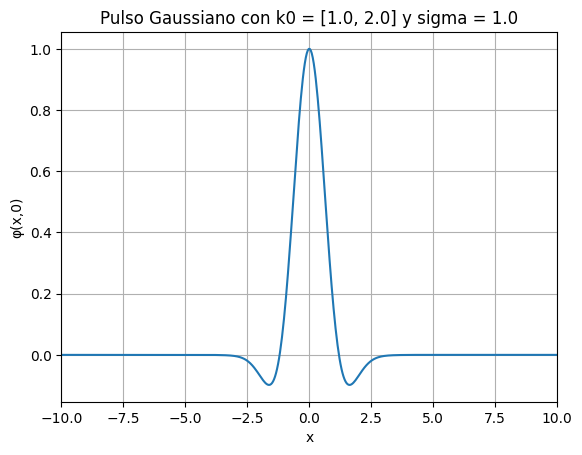

In [ ]:
#Graficar la condicion inicial
plt.plot(x_grid.flatten(), phi0_vals.flatten())
plt.title(f"Pulso Gaussiano con k0 = {k0_sim} y sigma = {sigma}")
plt.xlabel("x")
plt.ylabel("φ(x,0)")
plt.grid(True)
plt.xlim(-10, 10)
plt.show()

In [ ]:
#Construcción del modelo
@tf.keras.utils.register_keras_serializable()
class SIRENLayer(tf.keras.layers.Layer):
    def __init__(self, units, omega0=30, is_first=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.omega0 = omega0
        self.is_first = is_first

    def build(self, input_shape):
        input_dim = int(input_shape[-1])

        if self.is_first:
            # Primera capa SIREN
            w = 1 / input_dim
        else:
            # Capas ocultas SIREN
            w = np.sqrt(6 / input_dim) / self.omega0

        # Inicialización especial SIREN
        initializer = tf.random_uniform_initializer(minval=-w, maxval=w)
        self.w = self.add_weight(
            shape=(input_dim, self.units), initializer=initializer, trainable=True
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros", trainable=True
        )

    def call(self, x):
        return tf.sin(self.omega0 * (tf.matmul(x, self.w) + self.b))


class PINN(tf.keras.Model):
    def __init__(self, layers, omega0):
        super().__init__()
        self.hidden = []
        self.omega0 = omega0

        # Iteramos sobre las capas para construirlas
        for i, units in enumerate(layers):
            # Usamos SIRENLayer en lugar de Dense
            self.hidden.append(SIRENLayer(
                units=units,
                omega0=omega0,
                is_first=(i == 0)
            ))

        # La capa de salida sigue siendo Dense lineal (para la predicción final)
        self.out = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x, t = inputs
        # Aseguramos que los inputs sean float64 y tengan la forma correcta
        x = tf.cast(x, dtype=tf.float64)
        t = tf.cast(t, dtype=tf.float64)

        X = tf.concat([x, t], axis=1)

        for layer in self.hidden:
            X = layer(X)

        return self.out(X)

In [ ]:
# FUNCIONES DE PÉRDIDA
# (a) Pérdida física (Ecuación de Klein–Gordon)
@tf.function
def pde_loss(model, x_f, t_f, c, m):
  with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x_f, t_f])
      with tf.GradientTape(persistent=True) as tape1:
          tape1.watch([x_f, t_f])
          phi = model([x_f, t_f])
      phi_x = tape1.gradient(phi, x_f)
      phi_t = tape1.gradient(phi, t_f)

  phi_xx = tape2.gradient(phi_x, x_f)
  phi_tt = tape2.gradient(phi_t, t_f)

  lambda_x = 2.0 / (X_max - X_min)
  lambda_t = 2.0 / (T_max - T_min)

  phi_xx = phi_xx * lambda_x**2
  phi_tt = phi_tt * lambda_t**2
  del tape1, tape2

  target_type = phi.dtype
  c_val = tf.cast(c, dtype=target_type)
  m_val = tf.cast(m, dtype=target_type)

  #Ecuación de Klein Gordon
  residual = phi_tt - (c_val**2) * phi_xx + (m_val**2) * phi
  return tf.reduce_mean(tf.square(residual))

# (b) Pérdida de condición inicial (phi0(x), pi0=0)
@tf.function
def initial_condition_loss(model, x_ic, t_ic, phi0_tf, pi0_tf):
  with tf.GradientTape() as tape:
      tape.watch(t_ic)
      phi_pred = model([x_ic, t_ic])
  phi_t_pred = tape.gradient(phi_pred, t_ic)
  phi_t_pred = phi_t_pred * (2.0 / (T_max - T_min))
  loss_phi = tf.reduce_mean(tf.square(phi_pred - phi0_tf))
  loss_pi  = tf.reduce_mean(tf.square(phi_t_pred - pi0_tf))
  return loss_phi + loss_pi

# (c) Pérdida de frontera (condiciones periódicas)
@tf.function
def boundary_condition_loss(model, t_bc, x_min_val, x_max_val):
    # x_min_val = -1.0 (normalizado), x_max_val = 1.0 (normalizado)
    lambda_x = (2.0 / (X_max - X_min))

    # Lado izquierdo (x = -1)
    x_left = tf.ones_like(t_bc) * -1.0
    with tf.GradientTape() as tape_l:
        tape_l.watch(x_left)
        phi_left = model([x_left, t_bc])

    lambda_x = (2.0 / (X_max - X_min))
    phi_x_left = tape_l.gradient(phi_left, x_left)*lambda_x

    # Lado derecho (x = 1)
    x_right = tf.ones_like(t_bc) * 1.0
    with tf.GradientTape() as tape_r:
        tape_r.watch(x_right)
        phi_right = model([x_right, t_bc])
    phi_x_right = tape_r.gradient(phi_right, x_right)*lambda_x

    # Error: Los valores y las derivadas deben ser iguales en ambos lados
    loss_val = tf.reduce_mean(tf.square(phi_left - phi_right))
    loss_der = tf.reduce_mean(tf.square(phi_x_left - phi_x_right))

    return loss_val + loss_der

# (e) Pérdida total combinada
@tf.function
def total_loss(model, x_f, t_f, x_ic, t_ic, phi0_tf, pi0_tf, x_bc, t_bc0, t_bcT, w, c_val, m_val):
  lf = pde_loss(model, x_f, t_f, c_val, m_val)
  li = initial_condition_loss(model, x_ic, t_ic, phi0_tf, pi0_tf)
  lb = boundary_condition_loss(model, x_bc, t_bc0, t_bcT)
  total = w[0]*lf + w[1]*li + w[2]*lb
  return total, (lf, li, lb)

In [ ]:
# Configuración rápida
tf.keras.backend.set_floatx('float64')

c = 1.0
m = 0.511

# Convertir c y m en float64
c = tf.constant(c, dtype=tf.float64)
m = tf.constant(m, dtype=tf.float64)

# Verificar que estamos usando GPU
print("Dispositivo físico:", tf.config.list_physical_devices('GPU'))

# Parámetros de la PINN
layers = [128, 128, 128, 128, 128, 128]
omega_ = 20
model = PINN(layers=layers, omega0=omega_)

# Decaimiento LR
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1500,
    decay_rate=0.95,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)

# Entrenamiento
epochs = 50000
print_every = 1000
alpha_lra = 0.9
w = np.array([1.0, 1.0, 1.0], dtype=np.float64)

lra_freq = 10

# PARÁMETROS DE ADAPTIVE SAMPLING (RAR-PINN)
as_freq = 1         # cada cuántas épocas activar AS
n_candidates = 128   # cuántos puntos generar
n_replace = 128       # cuántos puntos reemplazar
x_min, x_max = -40, 40
t_min, t_max = 0, (L/2 - 4*sigma)
# --------------------------------------------

# Historial
loss_history = {"epoch": [], "total": [], "pde": [], "ic": [], "bc": []}


# A. Paso de Entrenamiento Estándar
@tf.function
def train_step(model, x_f, t_f, x_ic, t_ic, phi0, pi0,
               x_bc_l, x_bc_r, t_bc, w_tensor, c_tf_param, m_tf_param):

    with tf.GradientTape() as tape:
        lf = pde_loss(model, x_f, t_f, c, m)
        li = initial_condition_loss(model, x_ic, t_ic, phi0, pi0)
        lb = boundary_condition_loss(model, x_bc_l, x_bc_r, t_bc)

        total_loss = w_tensor[0]*lf + w_tensor[1]*li + w_tensor[2]*lb

        tf.debugging.check_numerics(total_loss, "total_loss NaN/Inf")
        tf.debugging.check_numerics(lf, "pde_loss NaN/Inf")
        tf.debugging.check_numerics(li, "ic_loss NaN/Inf")
        tf.debugging.check_numerics(lb, "bc_loss NaN/Inf")

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.zeros_like(v) if g is None else g for g, v in zip(grads, model.trainable_variables)]
    grads, gnorm = tf.clip_by_global_norm(grads, 1.0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, lf, li, lb


# ============================================================
# B. Paso auxiliar para LRA
# ============================================================

@tf.function
def get_lra_gradients(model, x_f, t_f, x_ic, t_ic, phi0, pi0,
                      x_bc_l, x_bc_r, t_bc, c_tf_param, m_tf_param):

    with tf.GradientTape(persistent=True) as tape:
        lf = pde_loss(model, x_f, t_f, c_tf_param, m_tf_param)
        li = initial_condition_loss(model, x_ic, t_ic, phi0, pi0)
        lb = boundary_condition_loss(model, x_bc_l, x_bc_r, t_bc)

    target_layer_vars = model.trainable_variables[-2]

    grad_f = tape.gradient(lf, target_layer_vars)
    grad_i = tape.gradient(li, target_layer_vars)
    grad_b = tape.gradient(lb, target_layer_vars)

    max_f = tf.reduce_max(tf.abs(grad_f))
    max_i = tf.reduce_max(tf.abs(grad_i))
    max_b = tf.reduce_max(tf.abs(grad_b))

    mean_i = tf.reduce_mean(tf.abs(grad_i))
    mean_b = tf.reduce_mean(tf.abs(grad_b))

    lamb_i = max_f / (mean_i+1e-8)
    lamb_b = max_f / (mean_b+1e-8)

    #lamb_i = tf.clip_by_value(lamb_i, 0.1, 100.0)
    #lamb_b = tf.clip_by_value(lamb_b, 0.1, 100.0)

    return max_f, max_i, max_b, lamb_i, lamb_b


# C. STOCHASTIC RESAMPLING
def stochastic_resampling(n_points, interp_phi, interp_pi, X_min, X_max, T_min, T_max):
    """
    Genera nuevos puntos aleatorios y RECALCULA los valores objetivo (targets)
    para mantener la correspondencia correcta.
    """

    # 1. FÍSICA (Residual): Aleatorio en Espacio y Tiempo [-1, 1]
    # Asumimos que la red espera inputs normalizados [-1, 1]
    x_f_norm = np.random.uniform(-1, 1, (n_points, 1)).astype(np.float64)
    t_f_norm = np.random.uniform(-1, 1, (n_points, 1)).astype(np.float64)

    x_f_new = tf.convert_to_tensor(x_f_norm, dtype=tf.float64)
    t_f_new = tf.convert_to_tensor(t_f_norm, dtype=tf.float64)

    # 2. CONDICIÓN INICIAL (IC):
    # - Espacio: Aleatorio [-1, 1]
    # - Tiempo: FIJO en -1.0 (que representa t=0 físico)
    x_ic_norm = np.random.uniform(-1, 1, (n_points, 1)).astype(np.float64)
    t_ic_norm = np.full((n_points, 1), -1.0, dtype=np.float64) # SIEMPRE -1.0

    x_ic_new = tf.convert_to_tensor(x_ic_norm, dtype=tf.float64)
    t_ic_new = tf.convert_to_tensor(t_ic_norm, dtype=tf.float64)

    # --- RECALCULO DE TARGETS (CRÍTICO) ---
    # Convertir x_norm a x_phys para usar los interpoladores
    # x_phys = (x_norm + 1) * (max - min) / 2 + min
    x_ic_phys = (x_ic_norm + 1.0) * (X_max - X_min) / 2.0 + X_min

    # Evaluar interpoladores con las nuevas coordenadas físicas
    phi0_new_vals = interp_phi(x_ic_phys.flatten()).reshape(-1, 1)
    pi0_new_vals  = interp_pi(x_ic_phys.flatten()).reshape(-1, 1)

    phi0_new = tf.convert_to_tensor(phi0_new_vals, dtype=tf.float64)
    pi0_new  = tf.convert_to_tensor(pi0_new_vals, dtype=tf.float64)

    # 3. CONDICIÓN DE FRONTERA (BC):
    # - Tiempo: Aleatorio [-1, 1]
    # - Espacio: Fijo en extremos (-1 y 1)
    # Generamos el doble de puntos para cubrir izquierda y derecha
    t_bc_norm = np.random.uniform(-1, 1, (n_points, 1)).astype(np.float64)
    t_bc_new = tf.convert_to_tensor(t_bc_norm, dtype=tf.float64)

    # NOTA: Como x_bc_left y x_bc_right son fijos (-1 y 1), no necesitamos
    # regenerarlos, solo asegurarnos que su tamaño coincida con t_bc_new
    # en el train_step (usando broadcasting o regenerando si cambia N).

    return (x_f_new, t_f_new,
            x_ic_new, t_ic_new, phi0_new, pi0_new,
            t_bc_new)

# ENTRENAMIENTO
print(f"Iniciando entrenamiento optimizado por {epochs} épocas para Float64 ...")
start_time = time.time()

x_f_dyn = tf.identity(x_f_tf)
t_f_dyn = tf.identity(t_f_tf)

for epoch in range(1, epochs + 1):

    # Pesos tensor
    current_dtype = tf.keras.backend.floatx()
    w_tensor = tf.convert_to_tensor(w, dtype=current_dtype)

    # 1. Train step
    total_val, lf_val, li_val, lb_val = train_step(
        model, x_f_dyn, t_f_dyn, x_ic_tf, t_ic_tf, phi0_tf, pi0_tf,
        x_bc_left_tf, x_bc_right_tf, t_bc_tf, w_tensor, c, m
    )

    # 2. LRA
    if epoch % lra_freq == 0 and epoch > 1000:
        max_f, max_i, max_b, lamb_i_tf, lamb_b_tf = get_lra_gradients(
            model, x_f_dyn, t_f_dyn, x_ic_tf, t_ic_tf, phi0_tf, pi0_tf,
            x_bc_left_tf, x_bc_right_tf, t_bc_tf, c, m
        )

        lamb_i = float(lamb_i_tf.numpy())
        lamb_b = float(lamb_b_tf.numpy())

        w[1] = (1 - alpha_lra) * w[1] + alpha_lra * lamb_i
        w[2] = (1 - alpha_lra) * w[2] + alpha_lra * lamb_b

    # 3. STOCHASTIC RESAMPLING (Actualización correcta)
    if epoch % as_freq == 0:
        # Llamamos a la función corregida
        (x_f_dyn, t_f_dyn,
         x_ic_dyn, t_ic_dyn, phi0_dyn, pi0_dyn,
         t_bc_dyn) = stochastic_resampling(n_candidates, interp_phi0, interp_pi0,
              X_min, X_max, T_min, T_max
            )

    # Guardar historia
    loss_history["epoch"].append(epoch)
    loss_history["total"].append(total_val.numpy())
    loss_history["pde"].append(lf_val.numpy())
    loss_history["ic"].append(li_val.numpy())
    loss_history["bc"].append(lb_val.numpy())

    # print
    if epoch % print_every == 0 or epoch == 1:
        elapsed = time.time() - start_time
        print(f"Epoch {epoch}/{epochs} | T={total_val:.3e} | PDE={lf_val:.3e} | IC={li_val:.3e} | BC={lb_val:.3e} | Time: {elapsed:.1f}s")


# GUARDAR
df_loss = pd.DataFrame(loss_history)
df_loss.to_csv("training_loss_history_optimized.csv", index=False)
np.save("coeficientes_loss_w.npy", w)
model.save("PINN_KleinGordon_Optimized.keras")
print("Entrenamiento finalizado y guardado.")

Dispositivo físico: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Iniciando entrenamiento optimizado por 50000 épocas para Float64 ...
Epoch 1/50000 | T=2.375e+00 | PDE=3.903e-01 | IC=6.250e-01 | BC=1.359e+00 | Time: 5.1s
Epoch 1000/50000 | T=1.805e-03 | PDE=5.336e-04 | IC=9.879e-04 | BC=2.832e-04 | Time: 18.5s
Epoch 2000/50000 | T=1.240e-03 | PDE=3.793e-04 | IC=1.883e-03 | BC=1.909e-05 | Time: 36.6s
Epoch 3000/50000 | T=2.610e-03 | PDE=2.693e-04 | IC=3.758e-03 | BC=3.602e-04 | Time: 50.6s
Epoch 4000/50000 | T=2.129e-03 | PDE=4.263e-04 | IC=1.862e-03 | BC=2.146e-06 | Time: 64.6s
Epoch 5000/50000 | T=9.976e-04 | PDE=1.020e-04 | IC=5.794e-03 | BC=4.212e-05 | Time: 78.7s
Epoch 6000/50000 | T=4.154e-04 | PDE=1.473e-04 | IC=1.182e-03 | BC=1.808e-05 | Time: 92.6s
Epoch 7000/50000 | T=1.397e-03 | PDE=1.058e-03 | IC=1.307e-03 | BC=3.161e-06 | Time: 106.7s
Epoch 8000/50000 | T=2.176e-04 | PDE=9.058e-05 | IC=7.437e-04 | BC=5.429e-06 | Time: 120.7s
Epoch 9000/50000 | T=8.930e

In [ ]:
model.save_weights("pesos_fase1_rapida.weights.h5")
print("Pesos guardados")

Pesos guardados


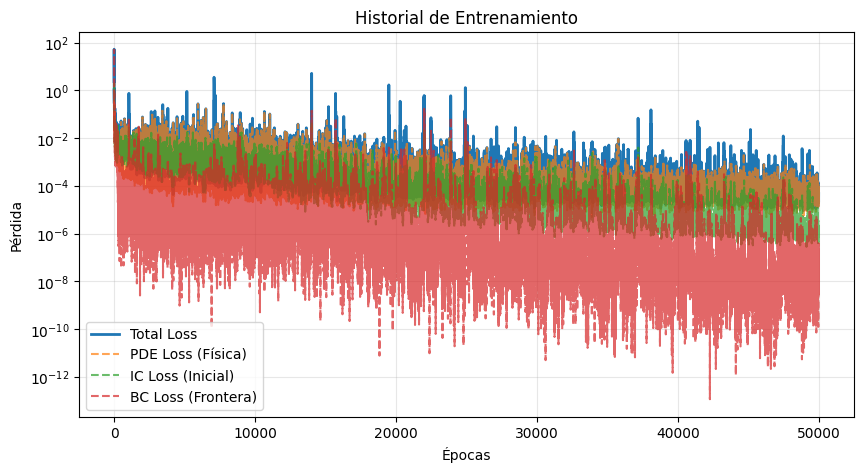

In [ ]:
# Gráfica de Convergencia (Loss History)
plt.figure(figsize=(10, 5))
plt.semilogy(loss_history["epoch"], loss_history["total"], label="Total Loss", linewidth=2)
plt.semilogy(loss_history["epoch"], loss_history["pde"], label="PDE Loss (Física)", linestyle="--", alpha=0.7)
plt.semilogy(loss_history["epoch"], loss_history["ic"], label="IC Loss (Inicial)", linestyle="--", alpha=0.7)
plt.semilogy(loss_history["epoch"], loss_history["bc"], label="BC Loss (Frontera)", linestyle="--", alpha=0.7)

plt.title("Historial de Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()

## **2.2. SEGUNDA PARTE:  Llegando al mínimo usando L-BFGS (Con Float64)**

In [ ]:
# ==========================================
# CONFIGURACIÓN GLOBAL Y CREACIÓN DE TENSORES (L-BFGS / FASE 2)
# ==========================================
print("1. Cambiando entorno a float64...")
tf.keras.backend.set_floatx('float64')
tf.random.set_seed(0)
np.random.seed(0)

c = 1.0
m = 0.511

# Función auxiliar estricta
def to_tensor_64(v):
    return tf.convert_to_tensor(v, dtype=tf.float64)

# -------------------------------------------------------------------------
# IMPORTANTE: Estas variables (x_f_norm, x_ic_phys, etc.)
# deben venir de la celda de "Generación de Datos" corregida anteriormente.
# -------------------------------------------------------------------------

# 1. Puntos de Colocación (Residuo PDE) -> Usamos coordenadas NORMALIZADAS
x_f_tf = to_tensor_64(x_f_norm)
t_f_tf = to_tensor_64(t_f_norm)

# 2. Condiciones Iniciales
# A) Inputs para la red -> NORMALIZADOS
x_ic_tf = to_tensor_64(x_ic_norm)
t_ic_tf = to_tensor_64(t_ic_norm)

# B) Valores Objetivo (Ground Truth) -> Calculados con coordenadas FÍSICAS
# Aquí está la corrección clave: interpolamos sobre el dominio real (-L/2 a L/2)
phi0_tf = to_tensor_64(interp_phi0(x_ic_phys).reshape(-1,1))
pi0_tf  = to_tensor_64(interp_pi0(x_ic_phys).reshape(-1,1))

# 3. Condiciones de Frontera -> Usamos coordenadas NORMALIZADAS
x_bc_left_tf  = to_tensor_64(x_bc_left_norm)
x_bc_right_tf = to_tensor_64(x_bc_right_norm)
t_bc_tf       = to_tensor_64(t_bc_norm)

# 4. Constantes
c_tf = tf.constant(c, dtype=tf.float64)
m_tf = tf.constant(m, dtype=tf.float64)

# Verificación de Sanidad
print("\n--- Verificación de Tensores (Float64) ---")
print(f"Inputs Red (Debe ser ~ -1 a 1):  Min {tf.reduce_min(x_ic_tf):.2f}, Max {tf.reduce_max(x_ic_tf):.2f}")
print(f"Targets Física (Debe tener forma de onda): Min {tf.reduce_min(phi0_tf):.4f}, Max {tf.reduce_max(phi0_tf):.4f}")

1. Cambiando entorno a float64...

--- Verificación de Tensores (Float64) ---
Inputs Red (Debe ser ~ -1 a 1):  Min -0.98, Max 0.96
Targets Física (Debe tener forma de onda): Min -0.0946, Max 0.9369


In [ ]:
#Modelo SIREN
tf.keras.backend.set_floatx('float64')

@tf.keras.utils.register_keras_serializable()
class SIRENLayer(tf.keras.layers.Layer):
    def __init__(self, units, omega0=30, is_first=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.omega0 = omega0
        self.is_first = is_first

    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        w = 1 / input_dim if self.is_first else np.sqrt(6 / input_dim) / self.omega0
        self.w = self.add_weight(
            shape=(input_dim, self.units),
            initializer=tf.random_uniform_initializer(-w, w),
            trainable=True,
            dtype=tf.float64
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            dtype=tf.float64
        )

    def call(self, x):
        x = tf.cast(x, tf.float64)
        return tf.sin(self.omega0 * (tf.matmul(x, self.w) + self.b))


class PINN(tf.keras.Model):
    def __init__(self, layers, omega0=30):
        super().__init__()
        self.hidden = []
        self.hidden.append(SIRENLayer(layers[0], omega0=omega0, is_first=True))
        for units in layers[1:]:
            self.hidden.append(SIRENLayer(units, omega0=omega0))
        self.out = tf.keras.layers.Dense(
            1,
            kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01),
            dtype=tf.float64
        )

    def call(self, inputs):
        x, t = inputs
        x = tf.cast(x, dtype=tf.float64)
        t = tf.cast(t, dtype=tf.float64)
        # -------------------

        X = tf.concat([x, t], axis=1)
        for layer in self.hidden:
            X = layer(X)
        return self.out(X)


In [ ]:
# CARGA DE PESOS
model = PINN(layers=[128]*6, omega0=20)
dummy = tf.zeros((1, 1), dtype=tf.float64)
_ = model([dummy, dummy])

print("3. Cargando pesos de Fase 1...")
try:
    print("Cargando coeficientes de pérdida (w) de la Fase 1...")
    w_loaded = np.load("coeficientes_loss_w.npy")

    model.load_weights("pesos_fase1_rapida.weights.h5")
    print("   -> ¡ÉXITO! Pesos y coeficientes cargados.")
except Exception as e:
    print(f"\n[ERROR FATAL] No se pudieron cargar los pesos: {e}")
    print("Deteniendo ejecución para evitar sobreescribir resultados.")
    sys.exit() # Detenemos aquí si falla

3. Cargando pesos de Fase 1...
Cargando coeficientes de pérdida (w) de la Fase 1...
   -> ¡ÉXITO! Pesos y coeficientes cargados.


In [ ]:
class LBFGS_Optimizer:

    def __init__(self, model, x_f,t_f,x_ic,t_ic,phi0,pi0,x_bc_l,x_bc_r,t_bc,w_tensor,c,m):

        self.model = model

        self.x_f = tf.cast(x_f, tf.float64)
        self.t_f = tf.cast(t_f, tf.float64)

        self.x_ic = tf.cast(x_ic, tf.float64)
        self.t_ic = tf.cast(t_ic, tf.float64)
        self.phi0 = tf.cast(phi0, tf.float64)
        self.pi0 = tf.cast(pi0, tf.float64)

        self.x_bc_l = tf.cast(x_bc_l, tf.float64)
        self.x_bc_r = tf.cast(x_bc_r, tf.float64)
        self.t_bc = tf.cast(t_bc, tf.float64)

        self.w_tensor = tf.cast(w_tensor, tf.float64)
        self.c = tf.cast(c, tf.float64)
        self.m = tf.cast(m, tf.float64)

        self.shapes = [w.shape for w in self.model.trainable_variables]
        self.sizes  = [np.prod(s) for s in self.shapes]

        self.history = {
            'iter':[], 'loss_total':[], 'loss_pde':[], 'loss_ic':[], 'loss_bc':[]
        }

        self.iter_count=0
        self.log_freq=100


    def _set_weights(self, flat):
        if not tf.is_tensor(flat):
            flat = tf.convert_to_tensor(flat, tf.float64)
        p=0
        for var,shape,size in zip(self.model.trainable_variables,self.shapes,self.sizes):
            neww = tf.reshape(flat[p:p+size], shape)
            var.assign(neww)
            p += size

    @tf.function
    def _calculate_loss_components(self):

        # ================== PDE =========================
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([self.x_f, self.t_f])
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch([self.x_f, self.t_f])
                phi = self.model([self.x_f, self.t_f])

            phi_x = tape1.gradient(phi, self.x_f)
            phi_t = tape1.gradient(phi, self.t_f)

        lambda_x = 2 /(X_max - X_min)
        lambda_t = 2 /(T_max-T_min)
        phi_xx = tape2.gradient(phi_x, self.x_f) * lambda_x**2
        phi_tt = tape2.gradient(phi_t, self.t_f) * lambda_t**2

        del tape1, tape2

        lf = tf.reduce_mean(tf.square(phi_tt - self.c**2 * phi_xx + self.m**2 * phi))

        # ================== IC =========================
        with tf.GradientTape() as tape:
            tape.watch(self.t_ic)
            phi_ic = self.model([self.x_ic, self.t_ic])

        lambda_t = 2 /(T_max-T_min)
        phi_t_ic = tape.gradient(phi_ic, self.t_ic) * lambda_t

        li = tf.reduce_mean(tf.square(phi_ic - self.phi0)) + \
             tf.reduce_mean(tf.square(phi_t_ic - self.pi0))

        # ================== BC =========================
        with tf.GradientTape(persistent=True) as tbc:
            tbc.watch([self.x_bc_l, self.x_bc_r])
            phi_l = self.model([self.x_bc_l, self.t_bc])
            phi_r = self.model([self.x_bc_r, self.t_bc])

        lambda_x = 2 /(X_max - X_min)
        phi_x_l = tbc.gradient(phi_l, self.x_bc_l) * lambda_x
        phi_x_r = tbc.gradient(phi_r, self.x_bc_r) * lambda_x

        del tbc

        lb = tf.reduce_mean(tf.square(phi_l - phi_r)) + \
             tf.reduce_mean(tf.square(phi_x_l - phi_x_r))

        # ================== Total ======================
        total = self.w_tensor[0]*lf + self.w_tensor[1]*li + self.w_tensor[2]*lb

        return total, lf, li, lb

    def _loss_and_grads(self, flat_w):

        flat_w_tf = tf.convert_to_tensor(flat_w, tf.float64)
        self._set_weights(flat_w_tf)

        with tf.GradientTape() as tape:
            total, lf, li, lb = self._calculate_loss_components()

        grads = tape.gradient(total, self.model.trainable_variables)
        grads = [tf.zeros_like(w) if g is None else g for g,w in zip(grads, self.model.trainable_variables)]

        grads_flat = tf.concat([tf.reshape(g,[-1]) for g in grads], axis=0)

        return total.numpy(), grads_flat.numpy()


    def _callback(self, xk):
        self.iter_count += 1
        xk = tf.convert_to_tensor(xk, tf.float64)
        self._set_weights(xk)

        total, lf, li, lb = self._calculate_loss_components()

        self.history['iter'].append(self.iter_count)
        self.history['loss_total'].append(total.numpy())
        self.history['loss_pde'].append(lf.numpy())
        self.history['loss_ic'].append(li.numpy())
        self.history['loss_bc'].append(lb.numpy())

        if self.iter_count % self.log_freq == 0:
            print(f"[Iter {self.iter_count}] "
                  f"Total={total.numpy():.4e} | PDE={lf.numpy():.4e} | IC={li.numpy():.4e} | BC={lb.numpy():.4e}")


    def fit(self, max_iter=5000):

        initial = tf.concat([tf.reshape(w,[-1]) for w in self.model.trainable_variables], axis=0)

        print("Iniciando L-BFGS...")

        result = minimize(
            fun=self._loss_and_grads,
            x0=initial.numpy(),
            method='L-BFGS-B',
            jac=True,
            callback=self._callback,
            options={'maxiter':max_iter, 'maxfun':50000, 'ftol':1*np.finfo(float).eps}
        )

        self._set_weights(tf.convert_to_tensor(result.x, dtype=tf.float64))

        print(f"Optimización finalizada. Loss={result.fun:.6e}")
        return result

    def save_weights(self, filename="pesos_pinns_LBFGS_float64.weights.h5"):
        self.model.save_weights(filename)
        print(f"Pesos guardados: {filename}")

    def save_csv(self, filename="KG_LBFGS_History.csv"):
        df = pd.DataFrame(self.history)
        df.to_csv(filename, index=False)
        print(f"Historia guardado: {filename}")

    def save_model(self, path="modelo_lbfgs_final.keras"):
        self.model.save(path)
        print(f"Modelo guardado en: {path}")

In [ ]:
# 1. Configurar float64 ANTES de crear nada
tf.keras.backend.set_floatx('float64')

# 2. Re-instanciar el modelo (ahora se creará con pesos float64)
model_64 = PINN(layers=[128]*6, omega0=20)

# 3. Construir el modelo (build) pasando un dummy input en float64
dummy = tf.zeros((1, 1), dtype=tf.float64)
_ = model_64([dummy, dummy])

# 4. Cargar los pesos de la Fase 1
model_64.load_weights("pesos_fase1_rapida.weights.h5")

# 5. AHORA inicias el LBFGS con 'model_64'
lbfgs = LBFGS_Optimizer(
    model=model_64,
    x_f=x_f_tf, t_f=t_f_tf,
    x_ic=x_ic_tf, t_ic=t_ic_tf,
    phi0=phi0_tf, pi0=pi0_tf,
    x_bc_l=x_bc_left_tf, x_bc_r=x_bc_right_tf,
    t_bc=t_bc_tf,
    w_tensor=w_loaded,
    c=c_tf, m=m_tf
)

print("Iniciando entrenamiento L-BFGS")
results = lbfgs.fit(max_iter=10000)

Iniciando entrenamiento L-BFGS
Iniciando L-BFGS...
[Iter 100] Total=5.3583e-07 | PDE=2.0357e-07 | IC=1.7627e-07 | BC=3.5065e-07
[Iter 200] Total=2.0036e-07 | PDE=4.2180e-08 | IC=9.3454e-08 | BC=1.1558e-07
[Iter 300] Total=7.7646e-08 | PDE=1.7328e-08 | IC=3.2949e-08 | BC=5.8545e-08
[Iter 400] Total=3.0055e-08 | PDE=6.2519e-09 | IC=9.9646e-09 | BC=3.9472e-08
Optimización finalizada. Loss=1.820439e-08


In [ ]:
#Guardar el modelo
lbfgs.save_model("modelo_lbfgs_final.keras")
print("Modelo guardado")

#guardar los pesos
lbfgs.save_weights("pesos_pinns_LBFGS_float64.weights.h5")
print("Pesos guardados")

#guardar el historial
lbfgs.save_csv("historial_pinns_LBFGS_float64.csv")
print("Historial guardado")

Modelo guardado en: modelo_lbfgs_final.keras
Modelo guardado
Pesos guardados: pesos_pinns_LBFGS_float64.weights.h5
Pesos guardados
Historia guardado: historial_pinns_LBFGS_float64.csv
Historial guardado


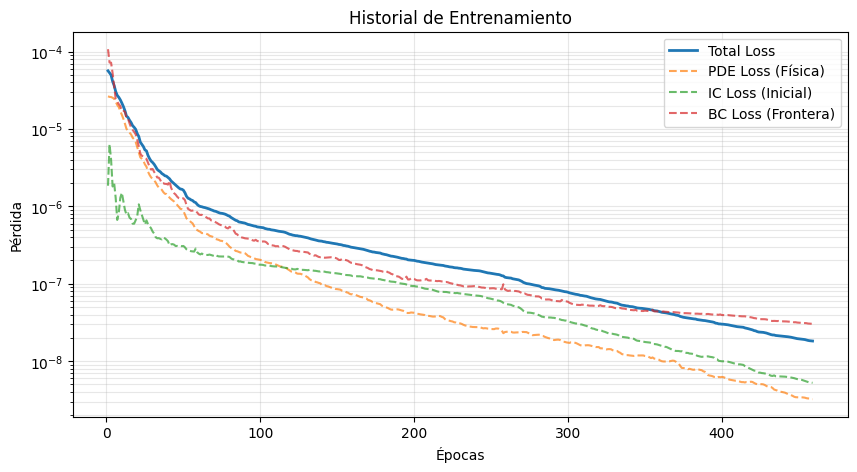

In [ ]:
# Gráfica de Convergencia (History)
plt.figure(figsize=(10, 5))
plt.semilogy(lbfgs.history["iter"], lbfgs.history["loss_total"], label="Total Loss", linewidth=2)
plt.semilogy(lbfgs.history["iter"], lbfgs.history["loss_pde"], label="PDE Loss (Física)", linestyle="--", alpha=0.7)
plt.semilogy(lbfgs.history["iter"], lbfgs.history["loss_ic"], label="IC Loss (Inicial)", linestyle="--", alpha=0.7)
plt.semilogy(lbfgs.history["iter"], lbfgs.history["loss_bc"], label="BC Loss (Frontera)", linestyle="--", alpha=0.7)

plt.title("Historial de Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()

# **3. Análisis de resultados**

In [ ]:
#input archivos en colab
from google.colab import files
uploaded = files.upload()

In [ ]:
# VOLVER A CREAR LA CLASE SIRENLayer y PINN para llamar el modelo nuevamente con la precisión de 64.
tf.keras.backend.set_floatx('float64')

@tf.keras.utils.register_keras_serializable()
class SIRENLayer(tf.keras.layers.Layer):
    def __init__(self, units=128, omega0=30, is_first=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.omega0 = omega0
        self.is_first = is_first

    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        w = 1 / input_dim if self.is_first else np.sqrt(6 / input_dim) / self.omega0
        self.w = self.add_weight(shape=(input_dim, self.units), initializer=tf.random_uniform_initializer(-w, w), trainable=True, dtype=tf.float64)
        self.b = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True, dtype=tf.float64)

    def call(self, x):
        return tf.sin(self.omega0 * (tf.matmul(tf.cast(x, tf.float64), self.w) + self.b))

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "omega0": self.omega0,
            "is_first": self.is_first,
        })
        return config

@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, layers=[128, 128, 128, 128, 128, 128], omega0=30, **kwargs):
        super().__init__(**kwargs)
        self.layers_list = layers
        self.omega0 = omega0

        self.hidden = []
        self.hidden.append(SIRENLayer(layers[0], omega0=omega0, is_first=True))
        for units in layers[1:]:
            self.hidden.append(SIRENLayer(units, omega0=omega0, is_first=False))
        self.out = tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.RandomUniform(-0.01, 0.01), dtype=tf.float64)

    def call(self, inputs):
        x, t = inputs
        X = tf.concat([x, t], axis=1)
        for layer in self.hidden:
            X = layer(X)
        return self.out(X)

    # Añadimos get_config para evitar futuros errores de serialización
    def get_config(self):
        config = super().get_config()
        config.update({
            "layers": self.layers_list,
            "omega0": self.omega0,
        })
        return config

In [ ]:
#Instanciar el modelo
model_64 = PINN(layers=[128, 128, 128, 128, 128, 128], omega0=20)

#Crear las variables de peso antes de cargarlas
# Esto es necesario para que se creen las variables de peso antes de cargarlos
dummy_x = tf.zeros((1, 1), dtype=tf.float64)
dummy_t = tf.zeros((1, 1), dtype=tf.float64)
_ = model_64([dummy_x, dummy_t])


#Input y carga del modelo keras
filename = "modelo_lbfgs_final.keras"
model_64.load_weights(filename)

#Hacer una prueba para ver si tiene sentido o no
pred = model_64([dummy_x, dummy_t])
print("Predicción de prueba (debe ser float64):", pred.dtype)
print("Valor:", pred.numpy())

Predicción de prueba (debe ser float64): <dtype: 'float64'>
Valor: [[-0.05522078]]


In [ ]:
from google.colab import files

#Llamar las variables Z
Z = files.upload()

#Leer el archivo Z
import io
# CÁLCULO DE ERRORES (Métricas de Rendimiento)
z_csv_content = Z['Z.csv'].decode('utf-8')

Saving Z.csv to Z.csv


Shape Z_pred (PINN): (1000, 1000)
Shape Z_sim (Real):  (1000, 1000)

>>> Error Relativo L2: 4.3508e-01 <<<


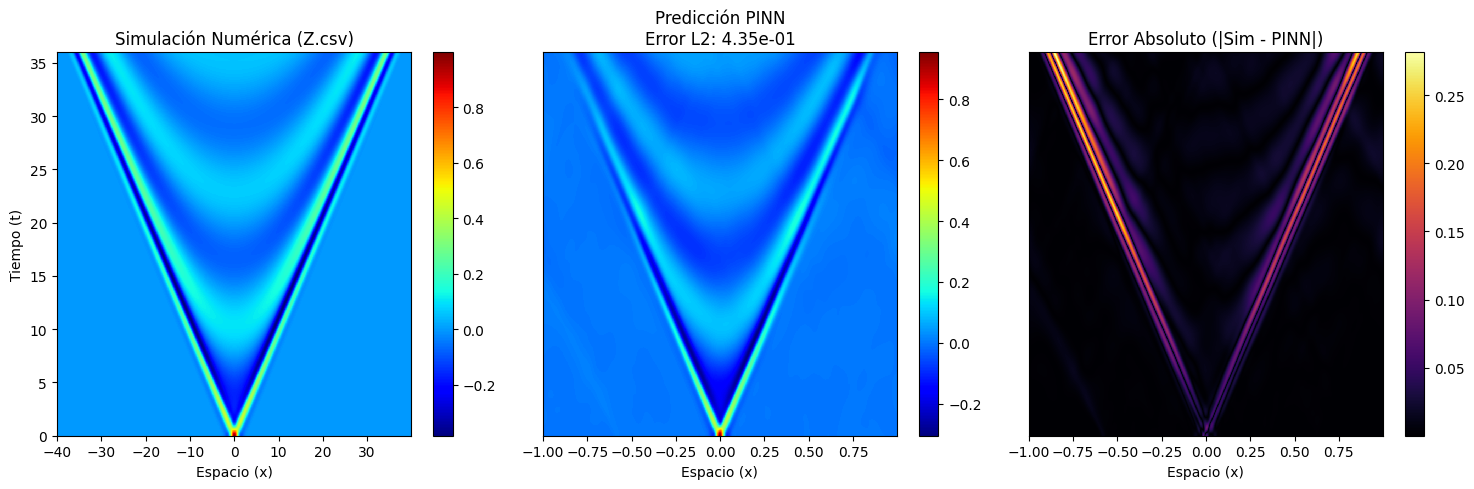

In [ ]:
# Estos valores vienen de tu archivo Klein_Gordon_Simulation_Final.ipynb
sigma = 1.0
L = 80 * sigma
N = 1000
T_max = L/2 - 4*sigma

# Definición de la Malla
x_phys = np.linspace(-L/2, L/2, N, endpoint=False)
t_phys = np.linspace(0, T_max, N, endpoint=True)

# 3. Malla
X_grid, T_grid = np.meshgrid(x_phys, t_phys)

# Valores de normalización
X_min, X_max = -L/2, L/2
T_min, T_max_train = 0, T_max

# 2. APLICAMOS EL MISMO ESCALADO DEL ENTRENAMIENTO
X_norm = 2.0 * (X_grid - X_min) / (X_max - X_min) - 1.0
T_norm = 2.0 * (T_grid - T_min) / (T_max - T_min) - 1.0

# 4. Flatten + tensores
X_test  = tf.convert_to_tensor(X_norm.flatten()[:,None], dtype=tf.float64)
T_test  = tf.convert_to_tensor(T_norm.flatten()[:,None], dtype=tf.float64)

# 5. Predicción
u_pred_flat = model.predict([X_test, T_test], batch_size=5000, verbose=0)
Z_pred = u_pred_flat.reshape(N, N)

#Cargar los datos reales:
Exact_df = pd.read_csv(io.StringIO(z_csv_content), header=None)
Z_sim = Exact_df.values

# --- DIAGNÓSTICO DE ERROR ---
print(f"Shape Z_pred (PINN): {Z_pred.shape}")
print(f"Shape Z_sim (Real):  {Z_sim.shape}")

## --- 5. CÁLCULO DE ERROR Y GRÁFICAS ---
error_l2 = np.linalg.norm(Z_sim - Z_pred) / np.linalg.norm(Z_sim)
print(f"\n>>> Error Relativo L2: {error_l2:.4e} <<<")

# Graficar
plt.figure(figsize=(15, 5))

# 1. Simulación Real
plt.subplot(1, 3, 1)
plt.pcolormesh(x_phys, t_phys, Z_sim, cmap='jet', shading='auto')
plt.title("Simulación Numérica (Z.csv)")
plt.xlabel("Espacio (x)")
plt.ylabel("Tiempo (t)")
plt.colorbar()

# 2. Predicción PINN
plt.subplot(1, 3, 2)
plt.pcolormesh(X_norm, T_norm, Z_pred, cmap='jet', shading='auto')
plt.title(f"Predicción PINN\nError L2: {error_l2:.2e}")
plt.xlabel("Espacio (x)")
plt.yticks([]) # Ocultar eje Y para limpieza visual
plt.colorbar()

# 3. Diferencia (Error Absoluto)
plt.subplot(1, 3, 3)
diff = np.abs(Z_sim - Z_pred)
plt.pcolormesh(X_norm, T_norm, diff, cmap='inferno', shading='auto')
plt.title("Error Absoluto (|Sim - PINN|)")
plt.xlabel("Espacio (x)")
plt.yticks([])
plt.colorbar()

plt.tight_layout()
plt.show()

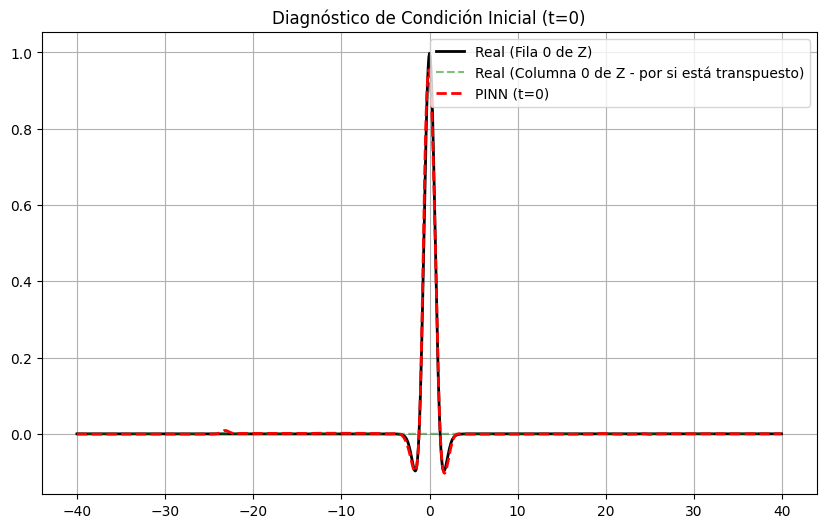

Rango de valores PINN: [-0.1034, 0.9545]
Rango de valores Real: [-0.3827, 0.9979]


In [ ]:
import matplotlib.pyplot as plt

# 1. Asegurar datos reales (re-cargar para estar seguros)
Exact_df = pd.read_csv(io.StringIO(z_csv_content), header=None)
Z_real = Exact_df.values

# Si Z_real es un vector plano, lo reformamos
if Z_real.ndim == 1 or Z_real.shape[1] == 1:
    Z_real = Z_real.reshape(N, N)

# 2. Generar predicción PINN para t=0 (Condición Inicial)
# Usamos solo vectores 1D para evitar confusiones de meshgrid
x_test_1d = np.linspace(-L/2, L/2, N, endpoint=False)
t_test_0 = np.zeros_like(x_test_1d) # t = 0

# Normalización IMPORTANTE (Revisa que X_min/max sean los mismos del entreno)
x_norm_1d = 2.0 * (x_test_1d - X_min) / (X_max - X_min) - 1.0
t_norm_0 = 2.0 * (t_test_0 - T_min) / (T_max - T_min) - 1.0

# Predicción en t=0
u_pred_t0 = model.predict([x_norm_1d.reshape(-1,1), t_norm_0.reshape(-1,1)], verbose=0)

# 3. GRAFICAR COMPARATIVA
plt.figure(figsize=(10, 6))

# Perfil Real (Intentamos filas y columnas por si acaso)
# Asumimos que el tiempo 0 está en la primera fila o primera columna
plt.plot(x_test_1d, Z_real[0, :], 'k-', linewidth=2, label="Real (Fila 0 de Z)")
plt.plot(x_test_1d, Z_real[:, 0], 'g--', alpha=0.5, label="Real (Columna 0 de Z - por si está transpuesto)")

# Perfil PINN
plt.plot(x_test_1d, u_pred_t0, 'r--', linewidth=2, label="PINN (t=0)")

plt.title("Diagnóstico de Condición Inicial (t=0)")
plt.legend()
plt.grid(True)
plt.show()

# REPORTE DE VALORES
print(f"Rango de valores PINN: [{np.min(u_pred_t0):.4f}, {np.max(u_pred_t0):.4f}]")
print(f"Rango de valores Real: [{np.min(Z_real):.4f}, {np.max(Z_real):.4f}]")